# Gene Expression Correlation Analysis with Clinical Outcomes

This notebook analyzes correlations between gene expression and clinical outcomes (Y1: Clinical pregnancy, Y2: Live birth).

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

## Data Loading and Preprocessing

In [11]:
# Load the dataset
df = pd.read_csv('raw_data/filtered_已经log2.csv')

# Rename clinical columns to English
column_mapping = {
    '临床妊娠结局': 'Y1',  # Clinical pregnancy outcome
    '活产结局': 'Y2',      # Live birth outcome  
    '体重指数': 'BMI',      # Body mass index
    '基础内分泌FSH': 'FSH', # Basal FSH
    '基础内分泌AMH': 'AMH', # Basal AMH
    '移植胚胎数': 'Embryo_Count'  # Number of transferred embryos
}

df = df.rename(columns=column_mapping)

print(f"Dataset shape: {df.shape}")
print(f"Available outcomes: Y1 (Clinical pregnancy), Y2 (Live birth)")
print(f"Y1 distribution: {df['Y1'].value_counts().to_dict()}")
print(f"Y2 distribution: {df['Y2'].value_counts().to_dict()}")

Dataset shape: (377, 40592)
Available outcomes: Y1 (Clinical pregnancy), Y2 (Live birth)
Y1 distribution: {0: 227, 1: 150}
Y2 distribution: {0: 259, 1: 118}


## Outcome Selection and Setup

In [12]:
# SELECT OUTCOME FOR ANALYSIS
# Change this variable to analyze different outcomes:
# 'Y1' for Clinical pregnancy outcome
# 'Y2' for Live birth outcome

SELECTED_OUTCOME = 'Y2'  # <<<< CHANGE THIS TO 'Y1' OR 'Y2'

print(f"Selected outcome: {SELECTED_OUTCOME}")
outcome_data = df[SELECTED_OUTCOME]
print(f"Outcome distribution:")
print(outcome_data.value_counts())
print(f"Outcome description: {outcome_data.describe()}")

# Get gene expression data (exclude clinical variables)
clinical_cols = ['Y1', 'Y2', 'BMI', 'FSH', 'AMH', 'Embryo_Count']
gene_cols = [col for col in df.columns if col not in clinical_cols]
gene_data = df[gene_cols].select_dtypes(include=[np.number])

print(f"\nNumber of gene expression features: {gene_data.shape[1]}")
print(f"Gene expression data shape: {gene_data.shape}")

Selected outcome: Y2
Outcome distribution:
Y2
0    259
1    118
Name: count, dtype: int64
Outcome description: count    377.000000
mean       0.312997
std        0.464330
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Y2, dtype: float64

Number of gene expression features: 40586
Gene expression data shape: (377, 40586)


## Correlation Analysis

In [13]:
# Compute correlations between genes and selected outcome
correlations = []
p_values = []
gene_names = []

print(f"Computing correlations with {SELECTED_OUTCOME}...")

# Remove samples with missing outcome data
valid_samples = ~outcome_data.isna()
outcome_clean = outcome_data[valid_samples]
gene_data_clean = gene_data[valid_samples]

print(f"Valid samples for analysis: {sum(valid_samples)} out of {len(outcome_data)}")

# Calculate Pearson correlations
for gene in gene_data_clean.columns:
    gene_expr = gene_data_clean[gene]
    
    # Skip genes with too many missing values
    if gene_expr.isna().sum() / len(gene_expr) > 0.5:
        continue
    
    # Remove NaN values for this gene
    valid_gene_samples = ~gene_expr.isna()
    combined_valid = valid_gene_samples
    
    if sum(combined_valid) < 20:  # Need at least 20 samples
        continue
    
    try:
        corr, p_val = pearsonr(gene_expr[combined_valid], outcome_clean[combined_valid])
        correlations.append(corr)
        p_values.append(p_val)
        gene_names.append(gene)
    except:
        continue

# Create results dataframe
results_df = pd.DataFrame({
    'Gene': gene_names,
    'Correlation': correlations,
    'P_Value': p_values,
    'Abs_Correlation': np.abs(correlations)
})

# Sort by absolute correlation
results_df = results_df.sort_values('Abs_Correlation', ascending=False)

print(f"\nCorrelation analysis completed for {len(results_df)} genes")
print(f"Mean absolute correlation: {results_df['Abs_Correlation'].mean():.4f}")
print(f"Max absolute correlation: {results_df['Abs_Correlation'].max():.4f}")

Computing correlations with Y2...
Valid samples for analysis: 377 out of 377

Correlation analysis completed for 40586 genes
Mean absolute correlation: 0.0408
Max absolute correlation: 0.2011


## Top Correlated Genes

In [14]:
# Show top correlated genes
print(f"Top 20 genes most correlated with {SELECTED_OUTCOME}:")
print("=" * 60)
top_20 = results_df.head(20)
for idx, row in top_20.iterrows():
    direction = "Positive" if row['Correlation'] > 0 else "Negative"
    print(f"{row['Gene']:12} | Corr: {row['Correlation']:7.4f} | P-val: {row['P_Value']:8.2e} | {direction}")

# Statistical significance
significant_genes = results_df[results_df['P_Value'] < 0.05]
highly_significant = results_df[results_df['P_Value'] < 0.01]

print(f"\nStatistical significance:")
print(f"Genes with p < 0.05: {len(significant_genes)} ({len(significant_genes)/len(results_df)*100:.1f}%)")
print(f"Genes with p < 0.01: {len(highly_significant)} ({len(highly_significant)/len(results_df)*100:.1f}%)")

Top 20 genes most correlated with Y2:
RETREG1      | Corr:  0.2011 | P-val: 8.45e-05 | Positive
SNRNP25      | Corr:  0.1967 | P-val: 1.21e-04 | Positive
JPT1         | Corr:  0.1964 | P-val: 1.24e-04 | Positive
ARG2         | Corr:  0.1959 | P-val: 1.29e-04 | Positive
HROB         | Corr:  0.1955 | P-val: 1.33e-04 | Positive
PLXNA4       | Corr: -0.1915 | P-val: 1.83e-04 | Negative
LINC01565    | Corr: -0.1913 | P-val: 1.86e-04 | Negative
LGALS7B      | Corr:  0.1891 | P-val: 2.21e-04 | Positive
LINC00261    | Corr: -0.1889 | P-val: 2.25e-04 | Negative
GABARAPL1    | Corr:  0.1863 | P-val: 2.75e-04 | Positive
TOB1         | Corr:  0.1861 | P-val: 2.79e-04 | Positive
MOCOS        | Corr:  0.1861 | P-val: 2.80e-04 | Positive
PLP2         | Corr:  0.1844 | P-val: 3.19e-04 | Positive
SND1-DT      | Corr:  0.1843 | P-val: 3.21e-04 | Positive
LINC02340    | Corr: -0.1826 | P-val: 3.65e-04 | Negative
FRMD4A       | Corr: -0.1816 | P-val: 3.93e-04 | Negative
SDCBP2       | Corr:  0.1809 | P-v

## Visualization of Results

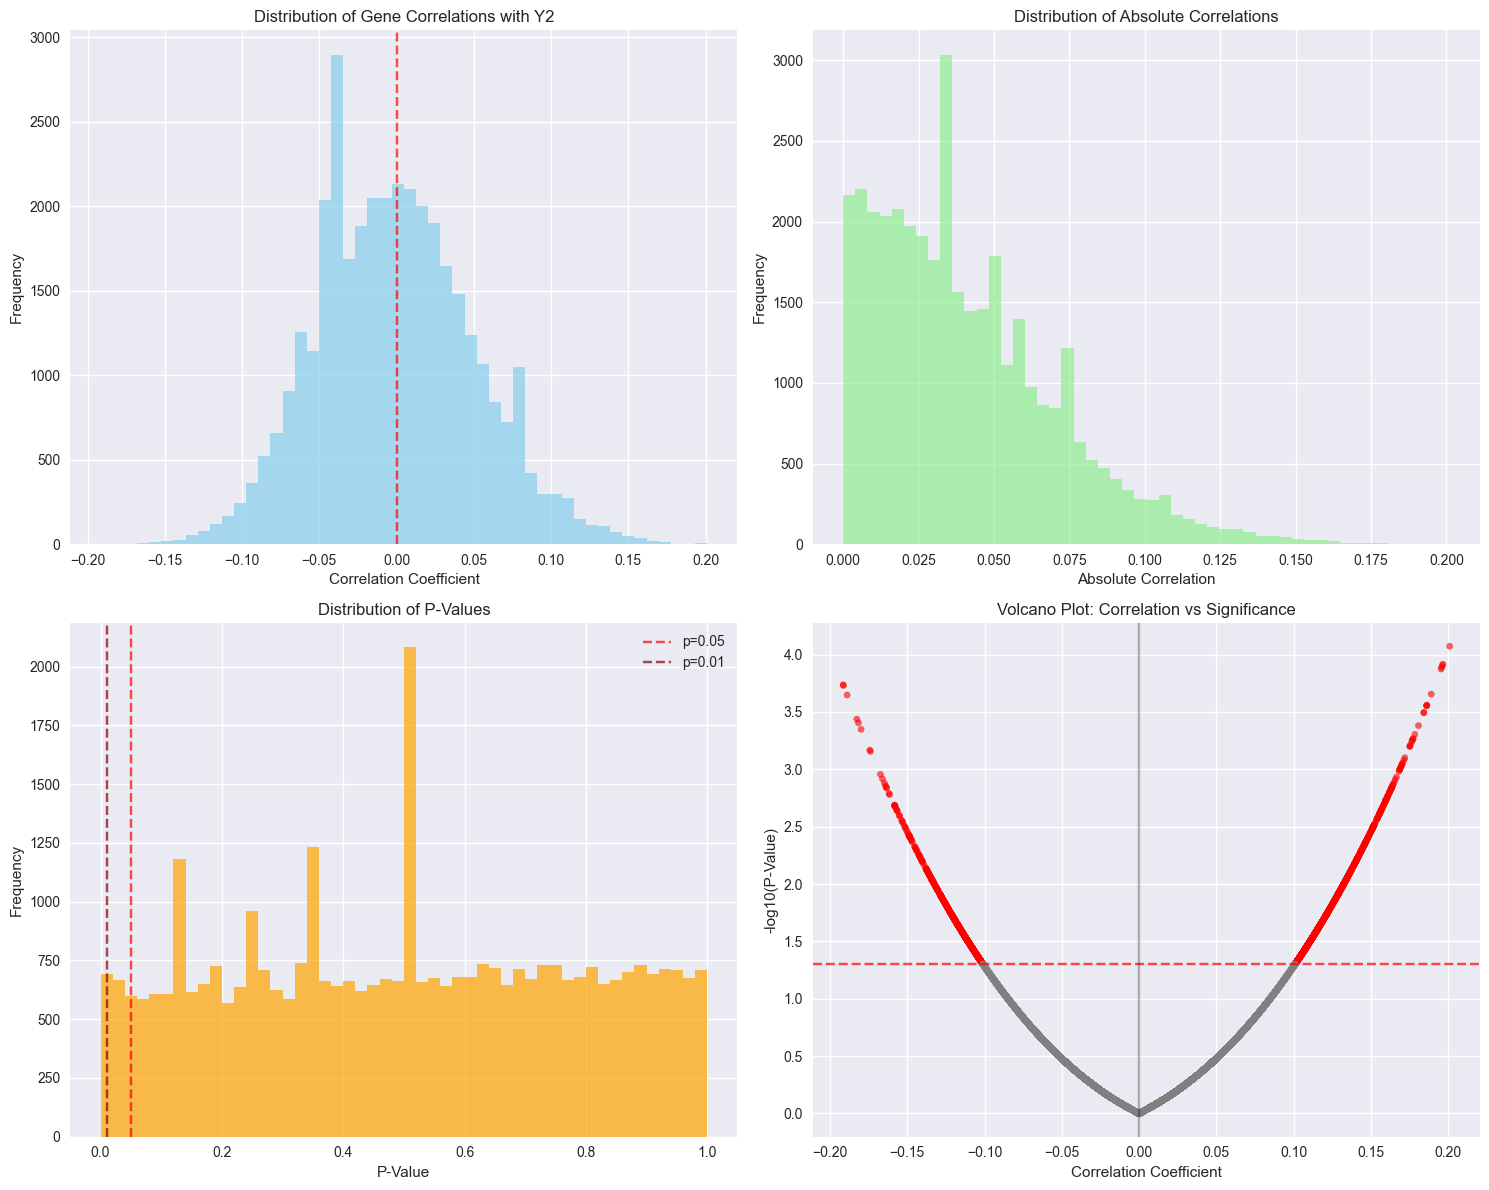

In [15]:
# Plot correlation distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Correlation distribution histogram
axes[0, 0].hist(results_df['Correlation'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('Correlation Coefficient')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Distribution of Gene Correlations with {SELECTED_OUTCOME}')

# 2. Absolute correlation distribution
axes[0, 1].hist(results_df['Abs_Correlation'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Absolute Correlation')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Absolute Correlations')

# 3. P-value distribution
axes[1, 0].hist(results_df['P_Value'], bins=50, alpha=0.7, color='orange')
axes[1, 0].axvline(0.05, color='red', linestyle='--', alpha=0.7, label='p=0.05')
axes[1, 0].axvline(0.01, color='darkred', linestyle='--', alpha=0.7, label='p=0.01')
axes[1, 0].set_xlabel('P-Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of P-Values')
axes[1, 0].legend()

# 4. Volcano plot
log_p = -np.log10(results_df['P_Value'])
colors = ['red' if p < 0.05 else 'gray' for p in results_df['P_Value']]
axes[1, 1].scatter(results_df['Correlation'], log_p, c=colors, alpha=0.6, s=20)
axes[1, 1].axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.7)
axes[1, 1].axvline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].set_ylabel('-log10(P-Value)')
axes[1, 1].set_title('Volcano Plot: Correlation vs Significance')

plt.tight_layout()
plt.show()

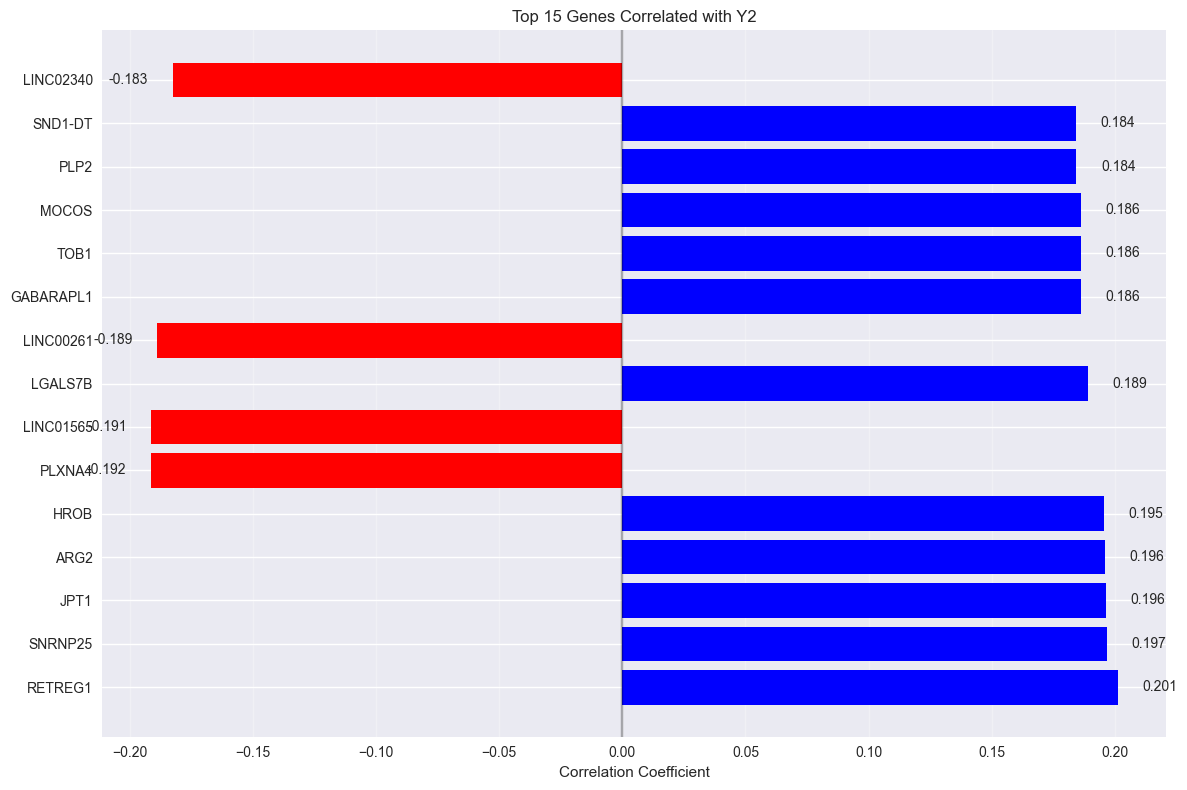

In [16]:
# Plot top 15 genes correlation coefficients
top_15 = results_df.head(15)
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_15)), top_15['Correlation'], 
                color=['red' if x < 0 else 'blue' for x in top_15['Correlation']])
plt.yticks(range(len(top_15)), top_15['Gene'])
plt.xlabel('Correlation Coefficient')
plt.title(f'Top 15 Genes Correlated with {SELECTED_OUTCOME}')
plt.axvline(0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add correlation values on bars
for i, (idx, row) in enumerate(top_15.iterrows()):
    plt.text(row['Correlation'] + (0.01 if row['Correlation'] > 0 else -0.01), i, 
             f"{row['Correlation']:.3f}", va='center', 
             ha='left' if row['Correlation'] > 0 else 'right')

plt.tight_layout()
plt.show()

## Detailed Analysis of Top Genes

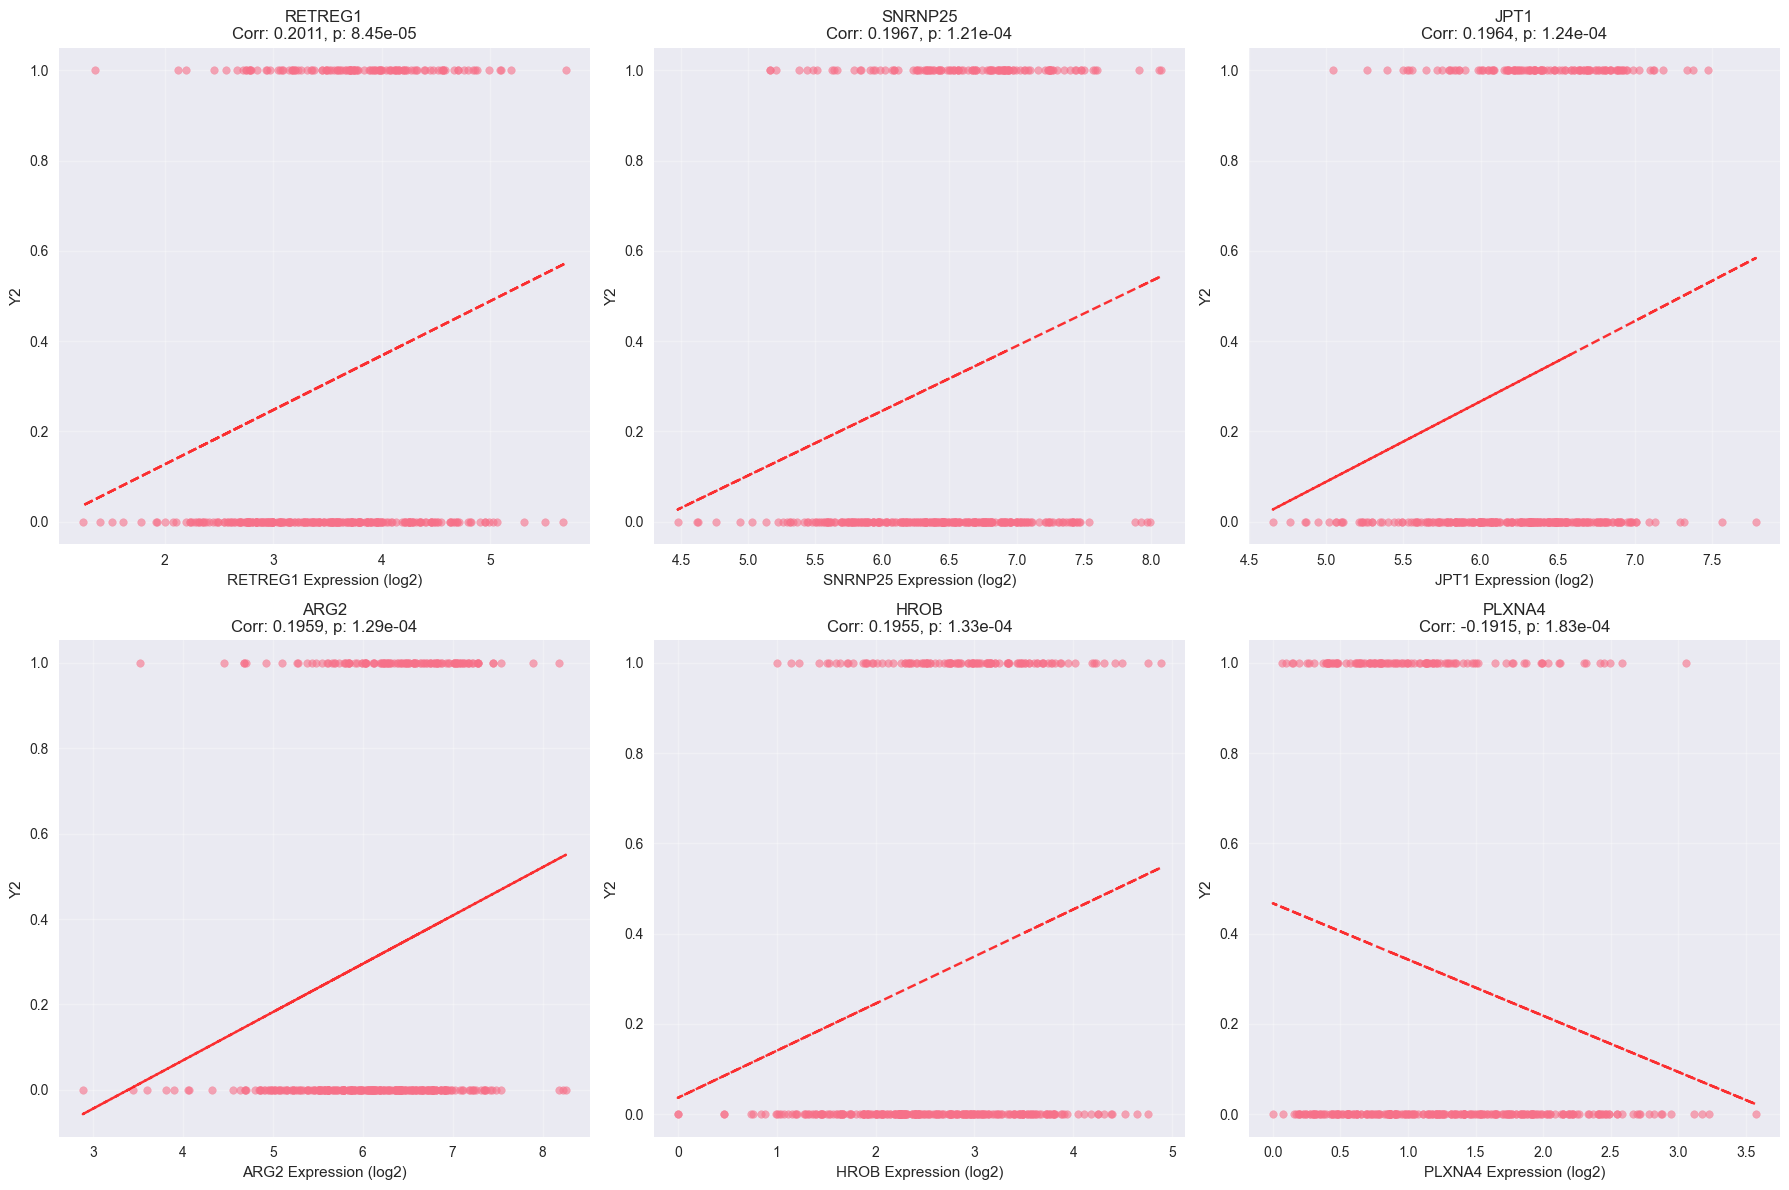

In [17]:
# Create scatter plots for top 6 correlated genes
top_6_genes = results_df.head(6)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (idx, row) in enumerate(top_6_genes.iterrows()):
    ax = axes[i//3, i%3]
    gene_name = row['Gene']
    
    # Get clean data for this gene
    gene_expr = gene_data_clean[gene_name]
    valid_samples = ~gene_expr.isna()
    
    x_data = gene_expr[valid_samples]
    y_data = outcome_clean[valid_samples]
    
    # Create scatter plot
    ax.scatter(x_data, y_data, alpha=0.6, s=30)
    
    # Add trend line
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    ax.plot(x_data, p(x_data), "r--", alpha=0.8)
    
    ax.set_xlabel(f'{gene_name} Expression (log2)')
    ax.set_ylabel(f'{SELECTED_OUTCOME}')
    ax.set_title(f'{gene_name}\nCorr: {row["Correlation"]:.4f}, p: {row["P_Value"]:.2e}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Conclusions

In [18]:
# Generate comprehensive summary
print(f"CORRELATION ANALYSIS SUMMARY FOR {SELECTED_OUTCOME}")
print("=" * 60)

# Basic statistics
print(f"Total genes analyzed: {len(results_df):,}")
print(f"Valid samples: {sum(valid_samples)}")

# Correlation strength categories
strong_pos = results_df[(results_df['Correlation'] > 0.3) & (results_df['P_Value'] < 0.05)]
moderate_pos = results_df[(results_df['Correlation'] > 0.1) & (results_df['Correlation'] <= 0.3) & (results_df['P_Value'] < 0.05)]
strong_neg = results_df[(results_df['Correlation'] < -0.3) & (results_df['P_Value'] < 0.05)]
moderate_neg = results_df[(results_df['Correlation'] < -0.1) & (results_df['Correlation'] >= -0.3) & (results_df['P_Value'] < 0.05)]

print(f"\nCORRELATION STRENGTH (p < 0.05):")
print(f"Strong positive (>0.3): {len(strong_pos)} genes")
print(f"Moderate positive (0.1-0.3): {len(moderate_pos)} genes")
print(f"Moderate negative (-0.3 to -0.1): {len(moderate_neg)} genes")
print(f"Strong negative (<-0.3): {len(strong_neg)} genes")

# Top findings
print(f"\nTOP FINDINGS:")
top_positive = results_df[results_df['Correlation'] > 0].head(3)
top_negative = results_df[results_df['Correlation'] < 0].head(3)

if len(top_positive) > 0:
    print(f"Most positively correlated gene: {top_positive.iloc[0]['Gene']} (r={top_positive.iloc[0]['Correlation']:.4f})")
if len(top_negative) > 0:
    print(f"Most negatively correlated gene: {top_negative.iloc[0]['Gene']} (r={top_negative.iloc[0]['Correlation']:.4f})")

print(f"\nSTATISTICAL SUMMARY:")
print(f"Mean correlation: {results_df['Correlation'].mean():.4f}")
print(f"Mean absolute correlation: {results_df['Abs_Correlation'].mean():.4f}")
print(f"Correlation range: {results_df['Correlation'].min():.4f} to {results_df['Correlation'].max():.4f}")
print(f"Significant correlations (p<0.05): {len(significant_genes)} ({len(significant_genes)/len(results_df)*100:.1f}%)")

# Biological interpretation
print(f"\nBIOLOGICAL INTERPRETATION:")
if SELECTED_OUTCOME == 'Y1':
    print("- Analyzing clinical pregnancy outcome")
    print("- Positive correlations suggest genes that promote successful pregnancy")
    print("- Negative correlations suggest genes that may inhibit pregnancy success")
elif SELECTED_OUTCOME == 'Y2':
    print("- Analyzing live birth outcome")
    print("- Positive correlations suggest genes supporting successful live birth")
    print("- Negative correlations suggest genes that may reduce live birth success")

print(f"\nRECOMMENDations:")
print("1. Focus on genes with |correlation| > 0.2 and p < 0.01 for further validation")
print("2. Perform functional enrichment analysis on top correlated genes")
print("3. Consider machine learning approaches using top correlated genes")
print("4. Validate findings in independent cohorts")

CORRELATION ANALYSIS SUMMARY FOR Y2
Total genes analyzed: 40,586
Valid samples: 377

CORRELATION STRENGTH (p < 0.05):
Strong positive (>0.3): 0 genes
Moderate positive (0.1-0.3): 1054 genes
Moderate negative (-0.3 to -0.1): 615 genes
Strong negative (<-0.3): 0 genes

TOP FINDINGS:
Most positively correlated gene: RETREG1 (r=0.2011)
Most negatively correlated gene: PLXNA4 (r=-0.1915)

STATISTICAL SUMMARY:
Mean correlation: -0.0011
Mean absolute correlation: 0.0408
Correlation range: -0.1915 to 0.2011
Significant correlations (p<0.05): 1669 (4.1%)

BIOLOGICAL INTERPRETATION:
- Analyzing live birth outcome
- Positive correlations suggest genes supporting successful live birth
- Negative correlations suggest genes that may reduce live birth success

RECOMMENDations:
1. Focus on genes with |correlation| > 0.2 and p < 0.01 for further validation
2. Perform functional enrichment analysis on top correlated genes
3. Consider machine learning approaches using top correlated genes
4. Validate fin

In [ ]:
# Save results to CSV
output_filename = f'correlation_results_{SELECTED_OUTCOME}.csv'
results_df.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")

# Save top significant genes
top_significant = results_df[(results_df['P_Value'] < 0.01) & (results_df['Abs_Correlation'] > 0.1)]
top_filename = f'top_genes_{SELECTED_OUTCOME}.csv'
top_significant.to_csv(top_filename, index=False)
print(f"Top significant genes saved to: {top_filename}")
print(f"Number of top genes: {len(top_significant)}")